In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
#from scipy import stats
#import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import hstack
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
#from sklearn.preprocessing import PolynomialFeatures, StandardScaler
#from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures

In [3]:
# Importar pickle con el dataset preprocesado
df = pd.read_pickle('DatasetFinalParaEntrenar.pkl')

### Fit & Transform

In [4]:
# Separar Variables por tipo
categoricals = ['property_type','place_name','state_name','zona']
descriptions = ['texto']
numericals = ['surface_total_in_m2', 'surface_covered_in_m2', 'floor', 'rooms', 'expenses','lat','lon']
dummies = ['subte','colectivo','balcon','tren','porton','financia', 'parrilla','pileta', 'solarium', 'lavadero', 'estacionamiento', 'no_apto_credito','apto_credito', 'amplioliving', 'cocheras', 'frente', 'contrafrente','seguridad', 'amenities', 'SUM', 'espaciosverdes','jacuzzi','estrenar','aptoprofesional','pozo','categoria','reciclado','luminoso','acondicionado','quincho','escalera']
target = ['price_usd_per_m2']

In [5]:
# Separar Train-Test

Xdf = df[np.concatenate([
        categoricals,
        descriptions,
        numericals,
        dummies
])]
Ydf = df[target]

X_trainDf, X_testDf, y_trainDf, y_testDf = train_test_split(Xdf, Ydf, test_size=0.30)

In [7]:
# FIT (función) - Vectorizar categóricas, Vectorizar texto en Description y Normalizar continuas
vectorizer = TfidfVectorizer(min_df=5)
enc = DictVectorizer()
clf = Ridge(1.0066666666666668, random_state=241,fit_intercept=True)
#clf = RidgeCV(alphas=np.linspace(0.01,3,10), cv=10, fit_intercept=True)
normalizer = preprocessing.Normalizer()
poly = PolynomialFeatures(degree = 1, include_bias = False)

def fit_model(X_train, Y_train):
    texts = X_train[descriptions]
    texts = texts.applymap(lambda x: x.lower())
    texts = texts.replace('[^a-zA-Z0-9]', ' ', regex = True)

    X_tfidf = vectorizer.fit_transform(texts[descriptions[0]])
    
    X_train_categ = enc.fit_transform(X_train[categoricals].to_dict('records'))
    
    X_numericas = poly.fit_transform(normalizer.fit_transform(X_train[numericals]))
    
    X_dummies = X_train[dummies]

    X = hstack([X_tfidf, X_train_categ, X_numericas, X_dummies]) # regualirzar las numericas luego de splitear
    
    # train model on data
    clf.fit(X, Y_train)
    return X, Y_train

X__train, y__train = fit_model(X_trainDf, y_trainDf)

In [8]:
clf.alpha_

1.0066666666666668

In [9]:
# TRANSFORM (función)
def transform_model(X_train):
    texts = X_train[descriptions]
    texts = texts.applymap(lambda x: x.lower())
    texts = texts.replace('[^a-zA-Z0-9]', ' ', regex = True)

    X_tfidf = vectorizer.transform(texts[descriptions[0]])
    
    X_train_categ = enc.transform(X_train[categoricals].to_dict('records'))
    
    X_numericas = poly.transform(normalizer.transform(X_train[numericals]))
    
    X_dummies = X_train[dummies]

    X = hstack([X_tfidf, X_train_categ, X_numericas, X_dummies])
    
    return X
X__test = transform_model(X_testDf)
X__test

<26910x21731 sparse matrix of type '<class 'numpy.float64'>'
	with 2161816 stored elements in COOrdinate format>

In [10]:
# Métricas
from sklearn import metrics
print ('Score de Entrenamiento: ',clf.score(X__train, y__train))
print ('Score de Test: ',clf.score(X__test, y_testDf))
print ('MAE: ', metrics.mean_absolute_error(y_testDf, clf.predict(X__test)))
print ('MSE: ', metrics.mean_squared_error(y_testDf, clf.predict(X__test)))
print ('RMSE: ', np.sqrt(metrics.mean_squared_error(y_testDf, clf.predict(X__test))))
print ('R2: ', metrics.r2_score(y_testDf, clf.predict(X__test)))

Score de Entrenamiento:  0.8125225020051304
Score de Test:  0.7347758211443604
MAE:  317.6019367920622
MSE:  235518.1767254946
RMSE:  485.3021499287785
R2:  0.7347758211443605


In [11]:
# Cross Validation CV=10
from sklearn.model_selection import cross_val_score
cross_val_score(clf, X__test, y_testDf, cv=10)

array([0.68616159, 0.70563632, 0.70086681, 0.75019213, 0.7105265 ,
       0.72761883, 0.7157732 , 0.72199002, 0.68502316, 0.68630679])

In [14]:
# Ejemplo
print(clf.predict(X__test)[10][0])
print(y_testDf.iloc[10,0])

833.7102375574545
980.103009708738


In [47]:
from joblib import dump
dump(clf, 'model_1.joblib')

### Crear dataset incluyendo predicciones y Ejericio Portafolio

In [15]:
# Reunir sets de entrenamiento y test
X_all, Y_all = fit_model(Xdf, Ydf)
# Calcular predicciones
valores = clf.predict(X_all)

In [49]:
# Volver a fittear el modelo ahora con todos los datos.
valores = clf.predict(X_all)

In [25]:
diferencia = Ydf - valores
diferencia.columns = ['diferencia_m2']
diferencia

diferencia.loc[:,'prediccion_m2'] = valores
diferencia.loc[:,'porcentaje_m2'] = Ydf / valores

dfR = df.join(diferencia)

dfR.loc[:,'prediccion_valor'] = dfR.prediccion_m2 * dfR.surface_total_in_m2

dfR = dfR[dfR.prediccion_m2 > 0]


portafolio = dfR.sample(n=100,random_state=100)

capital = portafolio.price_aprox_usd.sum()
print(capital)

dfR.sort_values(by='porcentaje_m2', ascending=True, inplace=True)
casas_compradas = pd.DataFrame([], columns=dfR.columns)
i = 0
ahorro = 0
while capital > 0:
    casa = dfR.iloc[i,:]
    valorCasa = casa.price_aprox_usd
    ahorro += casa.prediccion_valor - casa.price_aprox_usd
    casas_compradas = casas_compradas.append(casa)
    capital -= valorCasa
    i += 1
    
display(casas_compradas)

# Exportar casos a comprar a CSV
casas_compradas.to_csv('casas_compradas_ridge.csv')

print('Ahorro total: ', np.round(ahorro, 2))

18082619.756978013


,property_type,place_name,state_name,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,floor,...,reciclado,luminoso,acondicionado,quincho,escalera,texto,diferencia_m2,prediccion_m2,porcentaje_m2,prediccion_valor
51440,store,Posadas,Misiones,-27.364526,-55.897487,1323.331759,134.0,134.0,9.875610,0.0,...,0,0,0,0,0,LOCAL EN VENTA LOCALVENTA 3 Propiedades ubic...,-885.012852,894.888462,0.011036,1.199151e+05
104072,house,San Miguel,Bs.As. G.B.A. Zona Norte,-34.542267,-58.713495,5047.530000,456.0,456.0,11.069145,0.0,...,0,0,0,0,0,"Casa - San Miguel DOS DORMITORIOS, COCINA COME...",-948.877637,959.946782,0.011531,4.377357e+05
50632,house,Dique Luján,Bs.As. G.B.A. Zona Norte,-34.355907,-58.685825,12899.240000,1600.0,1600.0,8.062025,0.0,...,0,0,0,0,0,Casa en Dique Lujan. Cod.951 CODIGO: 1911-951 ...,-618.719427,626.781452,0.012863,1.002850e+06
58951,store,Bahía Blanca,Buenos Aires Interior,-38.719276,-62.271595,6231.510000,750.0,750.0,8.308680,0.0,...,0,0,0,0,0,GRAN SALON COMERCIAL - RONDEAU y GUEMES. CODIG...,-596.424667,604.733347,0.013739,4.535500e+05
40576,store,Oberá,Misiones,-27.498997,-55.121959,6231.510000,631.0,390.0,9.875610,0.0,...,0,0,0,0,0,PROPIEDAD CENTRICA EN OBERA CODIGO: 1834-024 u...,-542.683091,552.558702,0.017873,3.486645e+05
51890,store,General Rodríguez,Bs.As. G.B.A. Zona Oeste,-34.617390,-58.875983,8412.550000,300.0,300.0,28.041833,0.0,...,0,0,0,0,0,26 LOTES EXCEPCIONALES EN GENERAL RODRIGUEZ. 2...,-1266.716432,1294.758266,0.021658,3.884275e+05
19182,house,Belén de Escobar,Bs.As. G.B.A. Zona Norte,-34.346365,-58.781418,17000.000000,914.0,914.0,18.599562,0.0,...,0,0,0,0,0,"Casa 914m², Escobar, Belen de Escobar, por U$S...",-820.573801,839.173363,0.022164,7.670045e+05
21663,house,Los Cardales,Buenos Aires Interior,-36.576584,-60.228858,60000.000000,2500.0,2500.0,24.000000,0.0,...,0,0,0,0,0,"Casa 2500m², Exaltacion de la Cruz, Los Cardal...",-896.080691,920.080691,0.026085,2.300202e+06
29170,store,Centro / Microcentro,Capital Federal,-34.602029,-58.376690,14581.750000,365.0,365.0,39.950000,0.0,...,0,0,0,0,1,IMPORTANTE LOCAL EN SUB SUELO CON ENTRADA INDE...,-1488.504514,1528.454514,0.026138,5.578859e+05
47486,house,Pilar,Bs.As. G.B.A. Zona Norte,-34.447931,-58.873365,27000.000000,1045.0,1045.0,25.837321,0.0,...,0,0,0,0,0,"Casa 1045m², Bs.As. G.B.A. Zona Norte, Pilar, ...",-962.272057,988.109377,0.026148,1.032574e+06


Ahorro total:  129608995.64


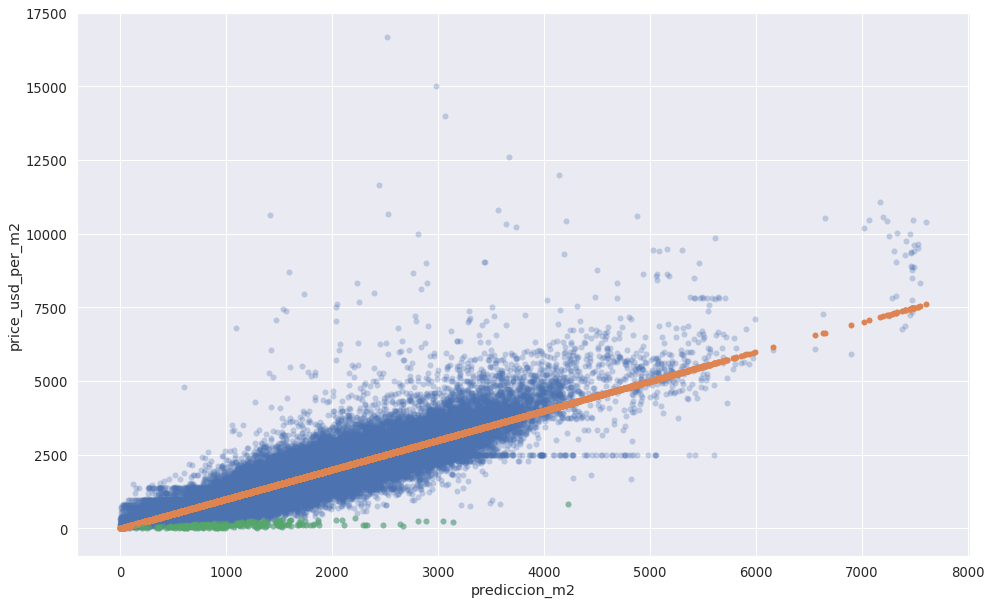

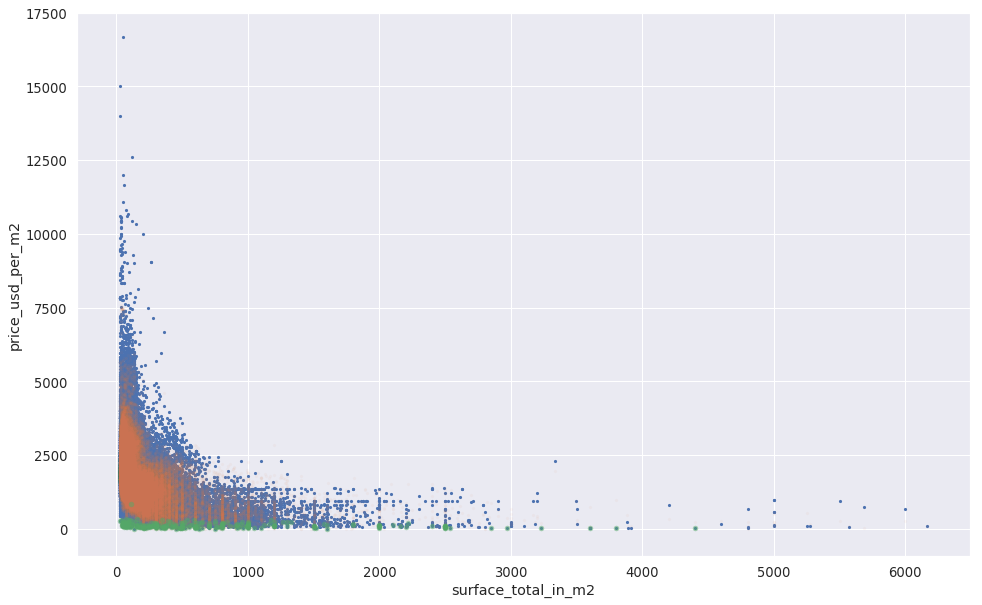

In [24]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

plt.subplots(figsize=(16,10))

sns.scatterplot(
    x="prediccion_m2", y="price_usd_per_m2", data=dfR, linewidth=0, alpha=0.3
)
sns.scatterplot(
    x="prediccion_m2", y="prediccion_m2", data=dfR, linewidth=0
)
sns.scatterplot(
    x="prediccion_m2", y="price_usd_per_m2", data=casas_compradas, linewidth=0, alpha=0.5
)

plt.show()

plt.subplots(figsize=(16,10))
sns.scatterplot(
        x="surface_total_in_m2", y="price_usd_per_m2",
        data=dfR,
        s=10, linewidth=0, alpha=1
)
sns.scatterplot(
        x="surface_total_in_m2", y="prediccion_m2",
        data=dfR,
        s=10, linewidth=0, alpha=0.05,
)
sns.scatterplot(
    x="surface_total_in_m2", y="price_usd_per_m2", data=casas_compradas, linewidth=0, alpha=0.5, s=30
)
plt.show()